
# Symbolic Manipulation and Finite Differences in Python
**A hands-on exercise notebook**  
Created: 2025-08-22

This notebook takes you from SymPy basics -> Taylor expansions -> deriving finite-difference stencils -> building and testing a 1D Poisson solver, with optional extensions. You'll implement small functions, run checks, and explore symbolic tooling that makes numerical methods cleaner and safer.



## Learning objectives
By the end, you will be able to:
- Manipulate symbolic expressions in SymPy (`symbols`, `expand`, `factor`, `subs`, `diff`, `series`, `lambdify`).
- Derive finite-difference weights from Taylor/moment conditions on arbitrary (even nonuniform) stencils.
- Find the order and the leading truncation-error (TE) constant of a stencil.
- Assemble and solve a 1D Poisson boundary-value problem with SciPy sparse.
- (Optional) Handle one-sided stencils for boundaries, and verify a simple heat-equation stability condition.



## 0) Setup
If needed, install packages (you can re-run safely):


In [1]:

# If running locally and you need packages, uncomment:
# !pip install sympy numpy scipy matplotlib
import sympy as sp
import numpy as np
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve
print("SymPy:", sp.__version__, "| NumPy:", np.__version__)


SymPy: 1.10.1 | NumPy: 1.21.5



## 1) SymPy basics (warm-up)
Complete the tasks and run the checks. If an assertion fails, adjust your code until it passes.
Tip: Keep everything symbolic (avoid floats) unless asked.


In [2]:

# 1.1 Symbols and expressions
x, y, h = sp.symbols('x y h')
a, b = sp.symbols('a b', nonzero=True)  # example symbols with assumptions

# Build a polynomial to play with:
expr = (x + 2*y)**3 - (x - y)*(x + y)

# TODO: Expand expr, then factor it back. Store results in expr_expanded, expr_factored
expr_expanded = sp.expand(expr)  # TODO: confirm/modify as needed
expr_factored = sp.factor(expr_expanded)  # TODO

# Checks
assert expr_expanded == sp.expand(expr)
assert sp.expand(expr_factored) == expr_expanded
expr_expanded, expr_factored


(x**3 + 6*x**2*y - x**2 + 12*x*y**2 + 8*y**3 + y**2,
 x**3 + 6*x**2*y - x**2 + 12*x*y**2 + 8*y**3 + y**2)

In [3]:

# 1.2 Substitution and evaluation
# Task: Substitute x=1, y=2 into expr and store as val_12 (as an exact integer if possible).
val_12 = expr.subs({x: 1, y: 2})
assert val_12 == expr.subs({x: 1, y: 2})
val_12


128

In [4]:

# 1.3 Differentiation
# Task: Compute first and second derivatives of sin(a*x) w.r.t. x.
f = sp.sin(a*x)
f1 = sp.diff(f, x)     # TODO
f2 = sp.diff(f, x, 2)  # TODO
assert sp.simplify(f1 - a*sp.cos(a*x)) == 0
assert sp.simplify(f2 + a**2*sp.sin(a*x)) == 0  # f'' = -a^2 sin(ax)
f1, f2


(a*cos(a*x), -a**2*sin(a*x))

In [5]:

# 1.4 Series expansion
# Task: Expand sin(x+h) as a series in h around h=0 up to O(h^6).
series_sin = sp.series(sp.sin(x + h), h, 0, 6)
series_sin


sin(x) + h*cos(x) - h**2*sin(x)/2 - h**3*cos(x)/6 + h**4*sin(x)/24 + h**5*cos(x)/120 + O(h**6)

In [15]:
#a simple way to convert the series to numical values
# 1) Drop the big-O term → pure polynomial in h
poly = series_sin.removeO()
val_h = sp.N(poly.subs(h, 0.1))  

# 2) Plug in x=1 (still a polynomial in h)
poly_x1 = sp.simplify(poly.subs(x, 1))

# 3a) Get a single numeric value by also setting h
val_h_0p1 = sp.N(poly_x1.subs(h, 0.1))   # or float(...)
print(val_h,' and a val ',val_h_0p1)

0.995004166666667*sin(x) + 0.0998334166666667*cos(x)  and a val  0.891207361240655


In [6]:

# 1.5 Lambdify: turn symbolic into numeric functions
# Task: Create a fast numeric function from g(x) = exp(-x**2) * cos(3x).
g = sp.exp(-x**2) * sp.cos(3*x)
g_num = sp.lambdify(x, g, "numpy")
xs = np.linspace(-2, 2, 5)
vals = g_num(xs)  # should be a NumPy array
vals


array([ 0.01758613, -0.36419789,  1.        , -0.36419789,  0.01758613])


## 2) Taylor series and moment matching for FD stencils
We approximate $f^{(d)}(x)$ by
    $$f^{(d)}(x) ~= (1/h)^d  \sum_j c_j \times f(x + s_j \times h).$$
The coefficients c_j are chosen so that the first m "moments" match:
$\sum_j c_j \times s_j^k = 0$ for $k != d$ and $\sum_j c_j \times s_j^d = d!$, for k = 0..m-1.
Fill in the functions below.


In [13]:

# 2.1 Implement finite-difference weights via moment matching
def _to_sympy_exact(s):
    # Try to keep integers/rationals exact; fall back to nsimplify
    try:
        return sp.nsimplify(s)
    except Exception:
        return sp.sympify(s)

def fd_weights(offsets, d):
    '''
    offsets: list/tuple of offsets s_j measured in grid steps (can be non-integers)
    d: derivative order (0 for identity, 1 for first derivative, 2 for second, ...)
    returns: sympy Matrix [c_j] with exact rational/closed forms where possible
    '''
    m = len(offsets)
    sym_off = [_to_sympy_exact(s) for s in offsets]
    # Build A_{k,j} = s_j**k, b_k = 0 except b_d = d!
    A = sp.Matrix([[sym_off[j]**k for j in range(m)] for k in range(m)])
    b = sp.Matrix([0]*m)
    b[d] = sp.factorial(d)
    c = A.LUsolve(b)
    return sp.simplify(c)

# Quick checks on known stencils (you can add more)
c1 = fd_weights([-1,0,1], d=2)  # classic 2nd derivative
assert list(c1) == [1, -2, 1]
# Check against a known function: f(x)=sin(x) ⇒ f'(x)=cos(x)
import numpy as np
x0 = 1.0
hval = 1e-3
offs = [-2,-1,0,1,2]
approx = sum(c2[j]*np.sin(x0 + offs[j]*hval) for j in range(len(offs))) / hval
print("FD approx:", approx, " | true:", np.cos(x0))



Matrix([[1], [-2], [1]])
FD approx: 0.540302305868073  | true: 0.5403023058681398


In [14]:

# 2.2 Implement leading truncation-error inspector
def leading_error_constant(offsets, d):
    '''
    Returns (p, C_p) such that TE ~ C_p * h**p * f^(d+p)(x).
    '''
    c = fd_weights(offsets, d)
    m = len(offsets)
    sym_off = [sp.nsimplify(s) for s in offsets]
    k = m
    while True:
        mom = sum(c[j] * sym_off[j]**k for j in range(m))
        if sp.simplify(mom) != 0:
            p = k - d
            Cp = sp.simplify(mom / sp.factorial(k))
            return int(p), Cp
        k += 1

# Check: 3-point second derivative has order 2 and TE const = 1/12
p_test, C_test = leading_error_constant([-1,0,1], d=2)
assert p_test == 2 and sp.simplify(C_test - sp.Rational(1,12)) == 0
p_test, C_test


Matrix([[1], [-2], [1]])


(2, 1/12)


### 2.3 Exercises
1) Use `fd_weights([-2,-1,0,1,2], d=2)` to get a 5-point fourth-order second-derivative stencil. Verify its order with `leading_error_constant`.

2) Derive a third-order one-sided first-derivative stencil at a boundary using offsets `[0, 1, 2, 3]`. What is the TE order and constant?

3) Try a nonuniform first-derivative stencil with offsets `[0, 0.5, 1.5]`. What order do you get?


In [ ]:

# Your work for 2.3 here. Feel free to add cells.
w_5pt_d2 = fd_weights([-2,-1,0,1,2], d=2)
order_5pt_d2, C_5pt_d2 = leading_error_constant([-2,-1,0,1,2], d=2)

w_one_sided = fd_weights([0,1,2,3], d=1)
order_one_sided, C_one_sided = leading_error_constant([0,1,2,3], d=1)

w_nonuniform = fd_weights([0, 0.5, 1.5], d=1)
order_nonuniform, C_nonuniform = leading_error_constant([0, 0.5, 1.5], d=1)

w_5pt_d2, (order_5pt_d2, C_5pt_d2), w_one_sided, (order_one_sided, C_one_sided), w_nonuniform, (order_nonuniform, C_nonuniform)



## 3) 1D Poisson with Dirichlet BCs
Solve -u''(x) = f(x) on [0,1] with u(0)=u(1)=0. We'll use a manufactured solution u(x)=sin(pi x) so f(x)=pi^2 sin(pi x).
Task: Implement the solver
- Build grid x of length n+2 with spacing h=1/(n+1).
- Assemble sparse tridiagonal matrix A = (1/h**2) * diag([-1, 2, -1]) for interior unknowns.
- Build RHS b = f(x_i) at interior points.
- Solve, insert Dirichlet boundaries, and return (x, u, u_true, err_inf) where err_inf is the max-norm error.


In [16]:

def poisson_1d_dirichlet(n):
    '''
    n: number of interior points
    Grid: x_i = i*h, i=0..n+1, h=1/(n+1)
    Returns: (x, u, u_true, err_inf)
    '''
    h = 1.0/(n+1)
    x = np.linspace(0.0, 1.0, n+2)
    u_true = np.sin(np.pi*x)
    f = (np.pi**2) * np.sin(np.pi*x)

    # assemble A on interior (n x n)
    main = 2.0*np.ones(n)
    off  = -1.0*np.ones(n-1)
    A = diags([off, main, off], offsets=[-1,0,1], shape=(n,n)) / (h**2)

    # interior RHS
    b = f[1:-1].copy()

    # Solve
    u_interior = spsolve(A, b)

    # Insert boundaries (Dirichlet zero)
    u = np.zeros_like(x)
    u[1:-1] = u_interior

    # Error
    err_inf = np.linalg.norm(u - u_true, ord=np.inf)
    return x, u, u_true, err_inf

# Smoke test
x, u, u_true, err = poisson_1d_dirichlet(63)
float(err)


/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


0.00020082180969560604


### 3.1 Convergence test (expected ~second-order)
Run the following cell. You should see roughly a 4x reduction in error when doubling n+1 (halving h).


In [17]:

errs = []
sizes = [31, 63, 127, 255]
for n in sizes:
    _, _, _, e = poisson_1d_dirichlet(n)
    errs.append(float(e))
    print(f"n={n:4d}  max|error|={e:.3e}")

ratios = [errs[i]/errs[i+1] for i in range(len(errs)-1)]
print("Error ratios (should be ~4):", ratios)


n=  31  max|error|=8.036e-04
n=  63  max|error|=2.008e-04
n= 127  max|error|=5.020e-05
n= 255  max|error|=1.255e-05
Error ratios (should be ~4): [4.001446260183585, 4.000361468367309, 4.0000903515629]



## 4) One-sided stencils and ghost points (boundary handling)
Suppose a Neumann BC at x=0: u'(0)=0. One approach is to create a ghost point u_{-1} and impose a one-sided derivative:
    u'(0) ~= (1/h) * sum_j c_j * u(x + s_j * h) = 0.
Exercise: Use fd_weights([0,1,2], d=1) (second-order one-sided) to express u_{-1} in terms of u_0, u_1, u_2 (or directly eliminate the ghost by a relation among boundary-adjacent unknowns). Write the relation you would plug into your linear system.


In [18]:

# Workpad: derive one-sided coefficients and form a relation for u'(0)=0
w_neu = fd_weights([0,1,2], d=1)
w_neu


Matrix([[-3/2], [2], [-1/2]])


Matrix([
[-3/2],
[   2],
[-1/2]])


## 5) (Optional) Von Neumann stability for the heat equation
Consider u_t = alpha * u_xx with explicit Euler in time and the 3-point stencil in space.
Show symbolically that a sufficient stability condition is dt <= h**2/(2*alpha).
Hint: The amplification factor is G(theta) = 1 - 4*mu*sin(theta/2)**2 where mu = alpha*dt/h**2.


In [19]:

theta, mu = sp.symbols('theta mu', real=True)
G = 1 - 4*mu*sp.sin(theta/2)**2
# Max of sin^2 is 1 -> stability requires |G| <= 1 for all theta.
# Show the most restrictive condition is 0 <= mu <= 1/2.
G_min = sp.simplify(G.subs({sp.sin(theta/2)**2: 1}))  # worst case -> 1 - 4*mu
sp.simplify(G_min), sp.simplify(sp.Abs(G_min))


(1 - 4*mu, Abs(4*mu - 1))


## 6) (Optional) 2D Poisson via Kronecker products
Use kron with 1D second-derivative matrices to assemble the 2D Laplacian on an interior N x N grid. Solve -Delta u = f with a manufactured solution, e.g. u(x,y) = sin(pi x) sin(pi y).


In [20]:

def lap1d_matrix(n, h):
    main = 2.0*np.ones(n)
    off  = -1.0*np.ones(n-1)
    return diags([off, main, off], [-1,0,1], shape=(n,n)) / (h**2)

def poisson_2d_dirichlet(N):
    '''
    2D Poisson with zero Dirichlet BCs on [0,1]^2.
    '''
    h = 1.0/(N+1)
    x = np.linspace(0,1,N+2)
    y = np.linspace(0,1,N+2)
    X, Y = np.meshgrid(x, y, indexing='ij')
    u_true = np.sin(np.pi*X) * np.sin(np.pi*Y)
    f = 2*(np.pi**2) * u_true

    # Interior
    F = f[1:-1, 1:-1].reshape(-1)

    L1 = lap1d_matrix(N, h)
    I  = eye(N, format='csr')
    A = kron(I, L1) + kron(L1, I)

    U = spsolve(A, F)
    u = np.zeros_like(u_true)
    u[1:-1, 1:-1] = U.reshape(N, N)

    err_inf = np.linalg.norm(u - u_true, ord=np.inf)
    return (x, y), u, u_true, err_inf

# Quick smoke test (small N)
_, _, _, err2d = poisson_2d_dirichlet(20)
float(err2d)


0.024844963743991765


## Wrap-up and next steps
- Try larger stencils (e.g., 7-point) and confirm higher orders.
- Build boundary stencils for Robin BCs with `fd_weights`.
- Explore performance: vectorize loops and use sparse formats efficiently.
- Extend the 2D solver to nonzero Dirichlet or mixed BCs.

Happy experimenting!



## 1.6 More SymPy skills: simplify, collect, apart/together
Practice algebraic manipulation utilities.


In [21]:

# Simplify, collect, apart/together
x, y = sp.symbols('x y')
expr = (x**2 - 1)/(x - 1) + (x/(x+1) + 1/(x+1))
s1 = sp.simplify(expr)
c1 = sp.collect(x**2 + 2*x + 1, x)
rat = (x**2 + x + 1)/(x**2 - 1)
ap = sp.apart(rat, x)      # partial fractions
tg = sp.together(ap)       # recombine
s1, c1, ap, tg


(x + 2,
 x**2 + 2*x + 1,
 1 - 1/(2*(x + 1)) + 3/(2*(x - 1)),
 (x + (x - 1)*(x + 1) + 2)/((x - 1)*(x + 1)))


## 1.7 Solving equations and linear systems symbolically


In [22]:

# Solve a nonlinear equation and a small linear system
x, y = sp.symbols('x y')
sol_scalar = sp.solve(sp.Eq(sp.sin(x), sp.Rational(1,2)), x)  # general solutions
A = sp.Matrix([[2, 1], [1, 3]])
b = sp.Matrix([1, 0])
sol_lin = A.LUsolve(b)  # exact rationals
sol_scalar[:4], sol_lin


([pi/6, 5*pi/6],
 Matrix([
 [ 3/5],
 [-1/5]]))


## 1.8 Piecewise and lambdify


In [23]:

t = sp.symbols('t', real=True)
f = sp.Piecewise((t**2, t < 0), (t, True))
f_num = sp.lambdify(t, f, "numpy")
import numpy as np
ts = np.linspace(-2, 2, 9)
vals = f_num(ts)
list(zip(ts.tolist(), vals.tolist()))


[(-2.0, 4.0),
 (-1.5, 2.25),
 (-1.0, 1.0),
 (-0.5, 0.25),
 (0.0, 0.0),
 (0.5, 0.5),
 (1.0, 1.0),
 (1.5, 1.5),
 (2.0, 2.0)]


## 2.4 Automatic order test on polynomials
A stencil that is exact on polynomials up to degree m-1 (except at k=d) should differentiate polynomials exactly up to that degree.


In [24]:

def test_stencil_exactness(offsets, d, maxdeg=None):
    '''
    Test that the FD approximation matches the exact derivative on polynomials
    of degree up to maxdeg (default: len(offsets)-1).
    '''
    m = len(offsets)
    if maxdeg is None:
        maxdeg = m-1
    c = fd_weights(offsets, d)
    s = [sp.nsimplify(si) for si in offsets]
    x, h = sp.symbols('x h')
    # Build generic polynomial p(x) = sum_{k=0..maxdeg} a_k x**k
    a = sp.symbols('a0:'+str(maxdeg+1))
    p = sum(a[k]*x**k for k in range(maxdeg+1))
    # FD approximation at x using samples at x + s_j*h
    fd = sum(c[j]*p.subs(x, x + s[j]*h) for j in range(m)) / (h**d)
    exact = sp.diff(p, x, d)
    # Compare series in h about 0 and drop O terms
    diff_series = sp.series(sp.simplify(fd - exact), h, 0, m).removeO()
    return sp.simplify(diff_series)

# Example: should be identically 0
res = test_stencil_exactness([-2,-1,0,1,2], d=1)
res


Matrix([[1/12], [-2/3], [0], [2/3], [-1/12]])


0


## 3.2 Plot the numerical solution and pointwise error


/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Text(0, 0.5, 'u(x)')

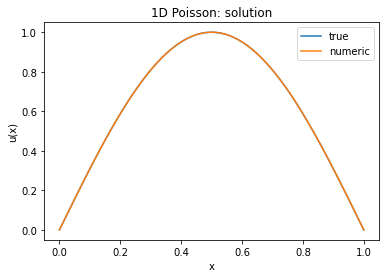

In [25]:

import matplotlib.pyplot as plt

x, u, u_true, err = poisson_1d_dirichlet(127)
plt.figure()
plt.plot(x, u_true, label="true")
plt.plot(x, u, label="numeric")
plt.legend()
plt.title("1D Poisson: solution")
plt.xlabel("x"); plt.ylabel("u(x)")


Text(0, 0.5, 'error')

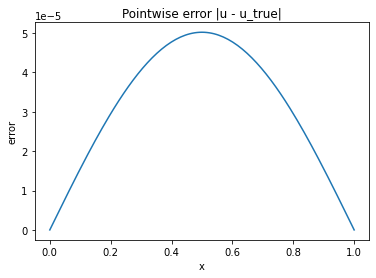

In [26]:

# Error plot
plt.figure()
plt.plot(x, np.abs(u - u_true))
plt.title("Pointwise error |u - u_true|")
plt.xlabel("x"); plt.ylabel("error")



## 3.3 Observed order of accuracy


In [27]:

def observed_orders(ns):
    errs = []
    for n in ns:
        _, _, _, e = poisson_1d_dirichlet(n)
        errs.append(float(e))
    orders = [np.log(errs[i]/errs[i+1])/np.log((n+1)/(ns[i+1]+1)) for i, n in enumerate(ns[:-1])]
    return errs, orders

ns = [31, 63, 127, 255]
errs, orders = observed_orders(ns)
for n, e in zip(ns, errs):
    print(f"n={n:4d}  max|error|={e:.3e}")
print("Observed orders:", orders)


n=  31  max|error|=8.036e-04
n=  63  max|error|=2.008e-04
n= 127  max|error|=5.020e-05
n= 255  max|error|=1.255e-05
Observed orders: [-2.0005215338201543, -2.0001303662649175, -2.0000325870698976]


/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',



## 5.1 Explicit heat equation solver
We solve u_t = alpha * u_xx on [0,1] with u=0 at boundaries and initial condition u(x,0)=sin(pi x).


In [28]:

def heat_explicit(alpha=1.0, n=99, tfinal=0.1, cfl=0.4):
    h = 1.0/(n+1)
    x = np.linspace(0,1,n+2)
    u = np.sin(np.pi*x)        # initial condition
    dt = cfl * h*h/alpha       # cfl <= 0.5 for stability
    msteps = int(np.ceil(tfinal/dt))
    dt = tfinal/msteps         # adjust to hit tfinal exactly
    r = alpha*dt/(h*h)
    for _ in range(msteps):
        un = u.copy()
        u[1:-1] = un[1:-1] + r*(un[0:-2] - 2*un[1:-1] + un[2:])
        u[0] = 0.0; u[-1] = 0.0
    u_true = np.exp(-np.pi**2*alpha*tfinal) * np.sin(np.pi*x)
    err_inf = np.linalg.norm(u - u_true, ord=np.inf)
    return x, u, u_true, err_inf, dt, msteps, r

# Stable run (cfl=0.4)
x, u, u_true, err_inf, dt, msteps, r = heat_explicit(alpha=1.0, n=199, tfinal=0.1, cfl=0.4)
print(f"dt={dt:.3e}, steps={msteps}, r={r:.3f}, max|error|={err_inf:.3e}")


dt=1.000e-05, steps=10000, r=0.400, max|error|=1.059e-05


Text(0, 0.5, 'u(x, t)')

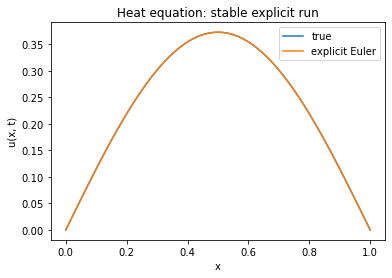

In [29]:

# Plot stable run
plt.figure()
plt.plot(x, u_true, label="true")
plt.plot(x, u, label="explicit Euler")
plt.legend()
plt.title("Heat equation: stable explicit run")
plt.xlabel("x"); plt.ylabel("u(x, t)")



### 5.2 An unstable step (for demonstration)
If cfl > 0.5, explicit Euler becomes unstable for this scheme.


(unstable) dt=1.750e-05, steps=5715, r=0.700, max|error|=nan


/var/folders/r3/b5v1s0gd7kq5f6lbp7zb_4rr0000gn/T/ipykernel_89062/1784012125.py:11: RuntimeWarning: overflow encountered in add
  u[1:-1] = un[1:-1] + r*(un[0:-2] - 2*un[1:-1] + un[2:])
/var/folders/r3/b5v1s0gd7kq5f6lbp7zb_4rr0000gn/T/ipykernel_89062/1784012125.py:11: RuntimeWarning: overflow encountered in subtract
  u[1:-1] = un[1:-1] + r*(un[0:-2] - 2*un[1:-1] + un[2:])
/var/folders/r3/b5v1s0gd7kq5f6lbp7zb_4rr0000gn/T/ipykernel_89062/1784012125.py:11: RuntimeWarning: invalid value encountered in add
  u[1:-1] = un[1:-1] + r*(un[0:-2] - 2*un[1:-1] + un[2:])
/var/folders/r3/b5v1s0gd7kq5f6lbp7zb_4rr0000gn/T/ipykernel_89062/1784012125.py:11: RuntimeWarning: invalid value encountered in subtract
  u[1:-1] = un[1:-1] + r*(un[0:-2] - 2*un[1:-1] + un[2:])


Text(0, 0.5, 'u(x, t)')

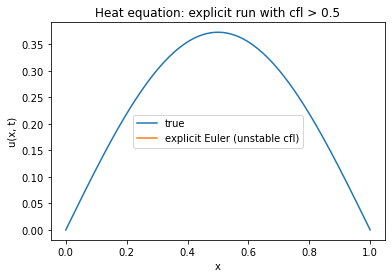

In [30]:

# Unstable run (expect oscillations/blow-up as tfinal grows)
x2, u2, u2_true, err2, dt2, m2, r2 = heat_explicit(alpha=1.0, n=199, tfinal=0.1, cfl=0.7)
print(f"(unstable) dt={dt2:.3e}, steps={m2}, r={r2:.3f}, max|error|={err2:.3e}")
plt.figure()
plt.plot(x2, u2_true, label="true")
plt.plot(x2, u2, label="explicit Euler (unstable cfl)")
plt.legend()
plt.title("Heat equation: explicit run with cfl > 0.5")
plt.xlabel("x"); plt.ylabel("u(x, t)")



## 6.1 SymPy code generation (C-style)
You can emit C-like code for stencil weights or expressions for embedding in other languages.


In [31]:

from sympy.printing.ccode import ccode
coeffs = fd_weights([-2,-1,0,1,2], d=1)
c_snippets = [ccode(sp.nsimplify(ci)) for ci in list(coeffs)]
c_snippets


Matrix([[1/12], [-2/3], [0], [2/3], [-1/12]])


/var/folders/r3/b5v1s0gd7kq5f6lbp7zb_4rr0000gn/T/ipykernel_89062/1085982615.py:1: SymPyDeprecationWarning: 

The sympy.printing.ccode submodule is deprecated. It has been renamed to
sympy.printing.c.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-printing-code-submodules
for details.

This has been deprecated since SymPy version 1.7. It
will be removed in a future version of SymPy.

  from sympy.printing.ccode import ccode


['1.0/12.0', '-2.0/3.0', '0', '2.0/3.0', '-1.0/12.0']

*Extended on 2025-08-22 15:54:52*